In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import plot_partial_dependence


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1.Import Data

In [0]:
# Import data from the data pre-processing part

df = pd.read_csv("/content/drive/Shared drives/Capstone Team 5/Submission/modeling.csv", index_col=0)

In [0]:
# Subset the target variable and predictors

y = df['target_reso']
#.ravel()
X = df.iloc[:,1:]

In [5]:
# Print the numbers of rows and columns

print(X.shape)
print(y.shape)

(1930, 137)
(1930,)


 # 2.Data Splitting

In [0]:
# Hold on 20% of dataas a validation dataset and put a seed in random state to yield the same splitting 

validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [7]:
# Print out the numbers of rows and columns in training and testing data

print("X_train: ",X_train.shape)
print("Y_train: ",Y_train.shape)
print("X_test: ",X_test.shape)
print("Y_test: ",Y_test.shape)

X_train:  (1544, 137)
Y_train:  (1544,)
X_test:  (386, 137)
Y_test:  (386,)


# 3.Modeling

In [0]:
# Make a list of models to fit and see which one has the best result
# We choose a common used classification models to spot-check model performances

models = []
models.append(('LR', LogisticRegression(max_iter=1000000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('SVM', SVC()))

LR: 0.697574 (0.035838)
LDA: 0.647084 (0.042445)
KNN: 0.676820 (0.024215)
CART: 0.794696 (0.024502)
RF: 0.869200 (0.027921)
SVM: 0.764248 (0.032439)


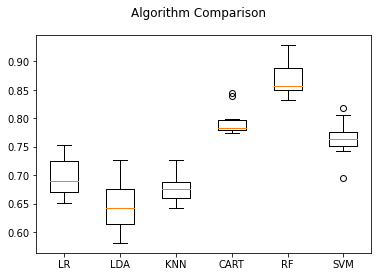

In [9]:
# Evaluate each model in turn with Stratified 10 Fold-Cross Validation using 80% dataset (X_train and Y_train) 
# It means using nine of ten folds to create models, and using the rest one fold to validate the model performance

# Create blank variables to store model name, results, and predictions
results = []
names = []
dwPreds = [] 
for name, model in models:
  # Specifiy stratified 10 Fold method
  skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
	# Store the metrics with the accuracy as the scoring method 
  cv_results = cross_val_score(model, X_train, Y_train, cv=skf, scoring='accuracy')
  # Append results and model name
  results.append(cv_results)
  names.append(name)
  # Print results
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)


# Model Comparisionwith box plots
# The best model is Random Forest with around 87% of average accuracy rate

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# 4.Model Evaluation

In [0]:
# Use 80% data to build a Random Forest model and make predictions

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, Y_train)

# Make predictions on validation dataset
test_pred = clf.predict(X_test)
train_pred = clf.predict(X_train)

In [11]:
print('Model performance using testing Dataset(20%):')
print('======================')
print('The mean accuracy rate: ',round(accuracy_score(Y_test, test_pred),4))
print(classification_report(Y_test, test_pred))

Model performance using testing Dataset(20%):
The mean accuracy rate:  0.8808
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       104
           1       1.00      0.80      0.89         5
           2       0.90      0.88      0.89       200
           3       0.93      0.90      0.92        63
           4       0.91      0.71      0.80        14

    accuracy                           0.88       386
   macro avg       0.91      0.84      0.87       386
weighted avg       0.88      0.88      0.88       386



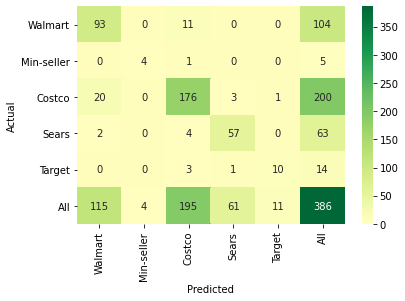

In [12]:
# Confusion matrix using testing Dataset(20%)
cm = pd.crosstab(Y_test, test_pred, rownames=['Actual'], colnames=['Predicted'], margins = True)
cm.rename(columns={0:'Walmart',1:'Min-seller',2:'Costco',3:'Sears', 4:'Target'}, index={0:'Walmart',1:'Min-seller',2:'Costco',3:'Sears', 4:'Target'},inplace=True)
sns.heatmap(cm, annot=True, fmt="d", center=cm.iloc[1,1],cmap="RdYlGn")

In [13]:
print('Model performance using training Dataset(80%):')
print('======================')
print('The mean accuracy rate: ',round(accuracy_score(Y_train, train_pred),4))
print(classification_report(Y_train, train_pred))

Model performance using training Dataset(80%):
The mean accuracy rate:  0.9793
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       458
           1       1.00      1.00      1.00        29
           2       0.99      0.98      0.98       765
           3       0.98      0.97      0.98       221
           4       1.00      1.00      1.00        71

    accuracy                           0.98      1544
   macro avg       0.99      0.99      0.99      1544
weighted avg       0.98      0.98      0.98      1544



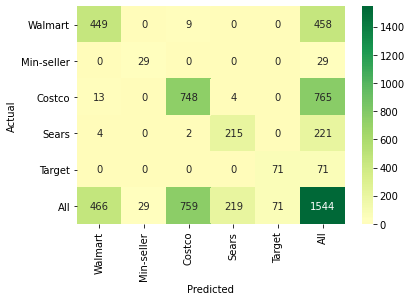

In [14]:
# Confusion matrix using training Dataset(80%)

cm = pd.crosstab(Y_train, train_pred, rownames=['Actual'], colnames=['Predicted'], margins = True)
cm.rename(columns={0:'Walmart',1:'Min-seller',2:'Costco',3:'Sears', 4:'Target'}, index={0:'Walmart',1:'Min-seller',2:'Costco',3:'Sears', 4:'Target'},inplace=True)
sns.heatmap(cm, annot=True, fmt="d", center=cm.iloc[1,1],cmap="RdYlGn")

# 5.Model Intepretation


## 5-1.Features Importance

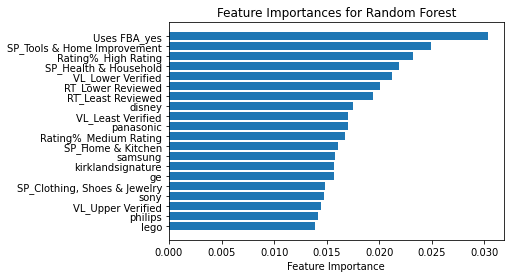

In [42]:
# Use built-in attributes of Random Forset model to determine important features
# The feature importance is calculated based on the number of times that the feature is used to split nodes

# We chose to select top 20 features to perform further analysis
num = 20

feature_importance = clf.feature_importances_
# make importances relative to max importance
sorted_idx_fi = np.argsort(feature_importance)[-num:]
pos = np.arange(sorted_idx_fi.shape[0]) + .5
plt.barh(pos[-num:], feature_importance[sorted_idx_fi], align='center')
plt.yticks(pos[-num:], X_train.columns[sorted_idx_fi])
plt.xlabel('Feature Importance')
plt.title('Feature Importances for Random Forest')
plt.show()

## 5-2.Partial Dependence Plots

In [0]:
# Create a list to hold top 20 important features and a dictionary to hold the target variable

fil = X_train.columns[sorted_idx_fi].to_list()
reso = {0:'Walmart',1:'Min-seller',2:'Costco',3:'Sears', 4:'Target'}

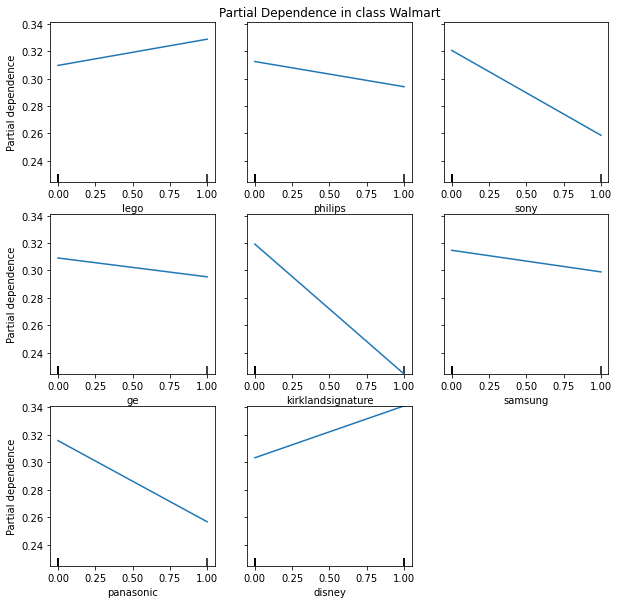

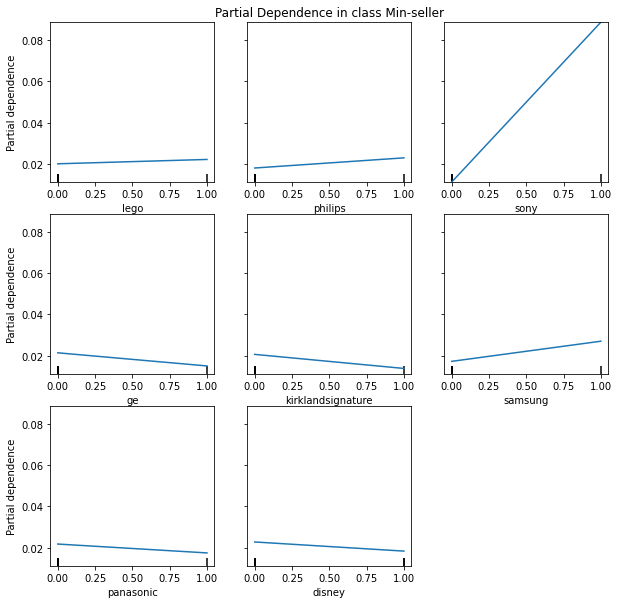

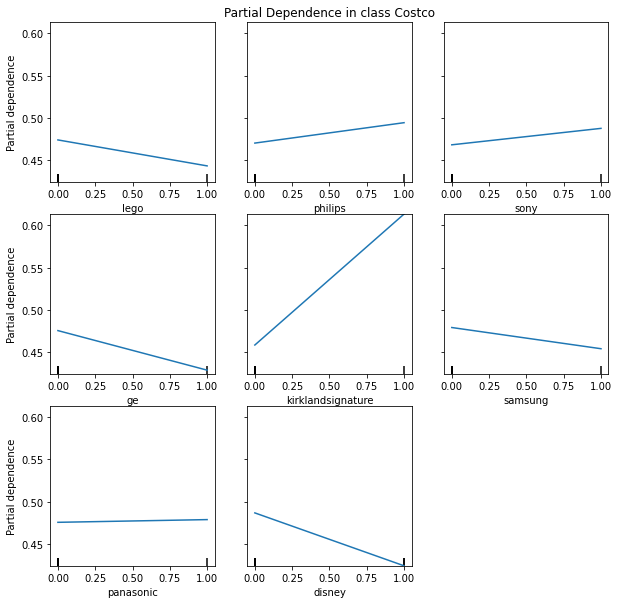

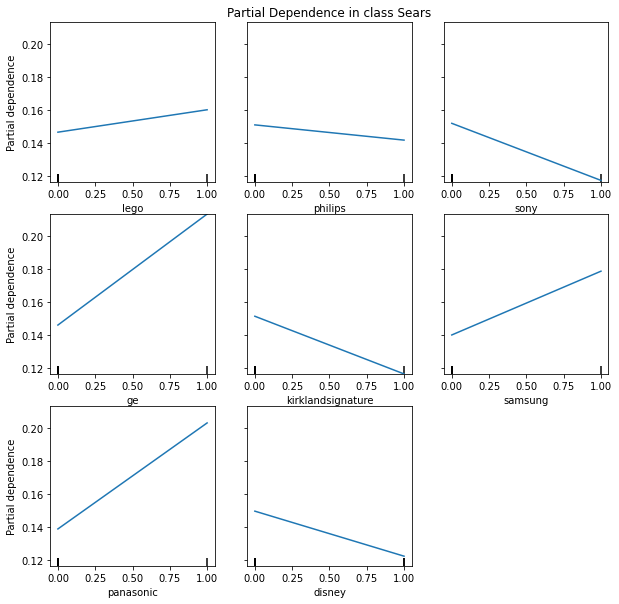

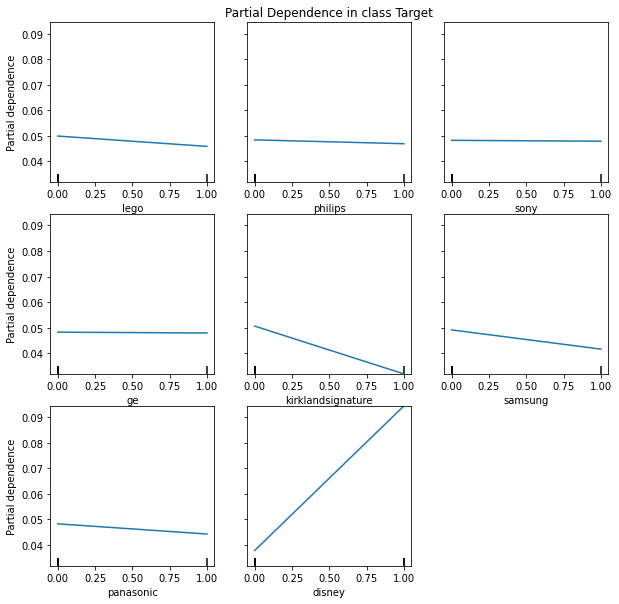

In [17]:
# Important brands of partial dependence plots

r = re.compile("^3|[a-z]")
brands = list(filter(r.match, fil))
brands

for i in range(len(reso)):
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.set_title("Partial Dependence in class %s" % reso[i])
  plot_partial_dependence(clf, X_train, brands, target=i,
                          n_jobs=3, grid_resolution=20,ax=ax)


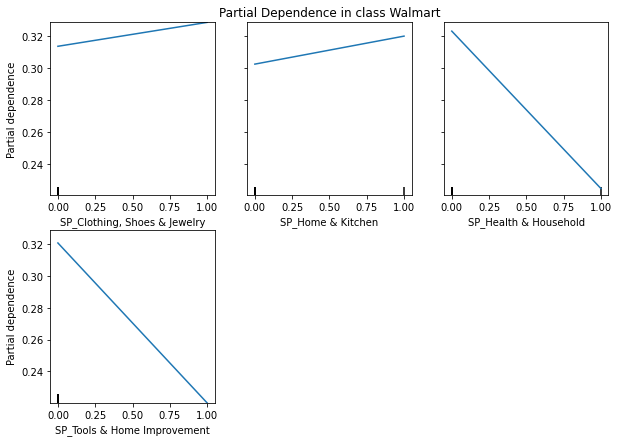

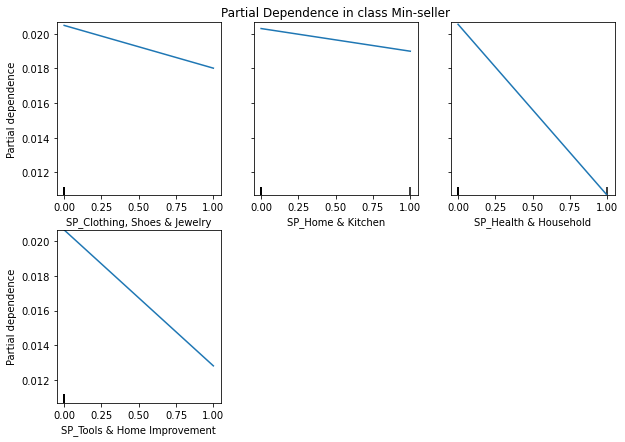

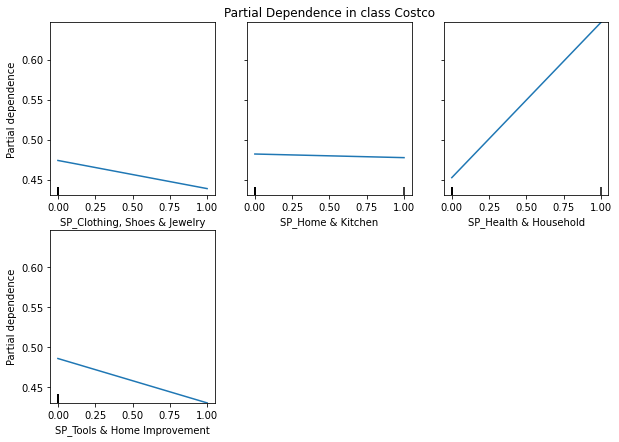

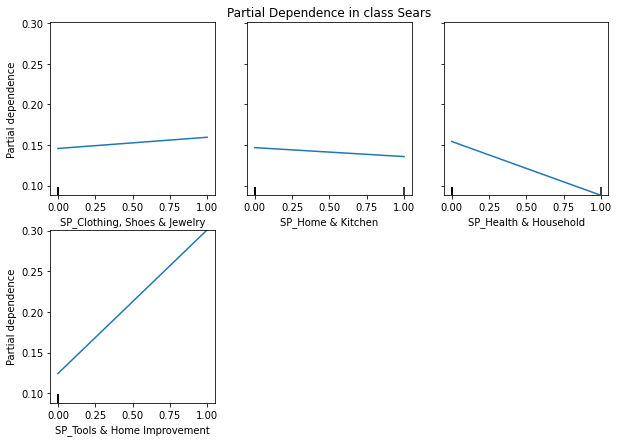

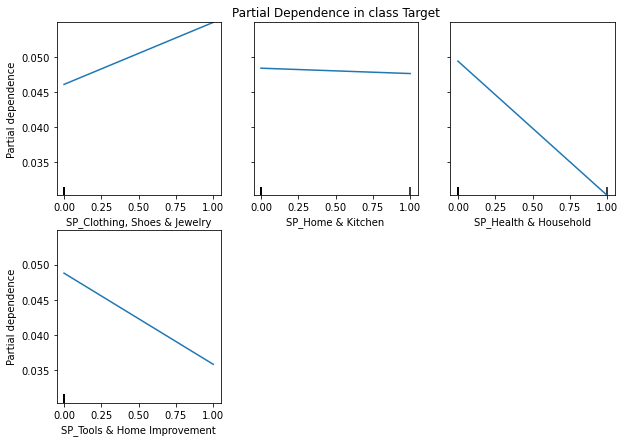

In [18]:
# Important selling preliminaries of partial dependence plots

r = re.compile("^SP_")
SP = list(filter(r.match, fil))

for i in range(len(reso)):
  fig, ax = plt.subplots(figsize=(10, 7))
  ax.set_title("Partial Dependence in class %s" % reso[i])
  plot_partial_dependence(clf, X_train,SP, target=i,
                          n_jobs=3,ax=ax)


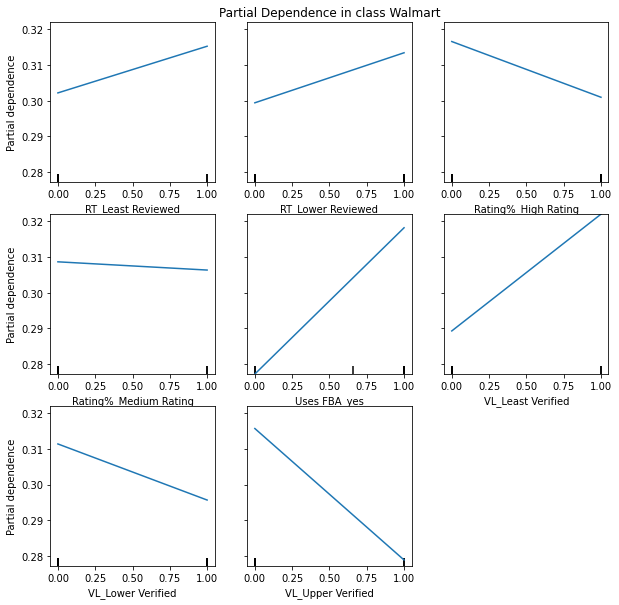

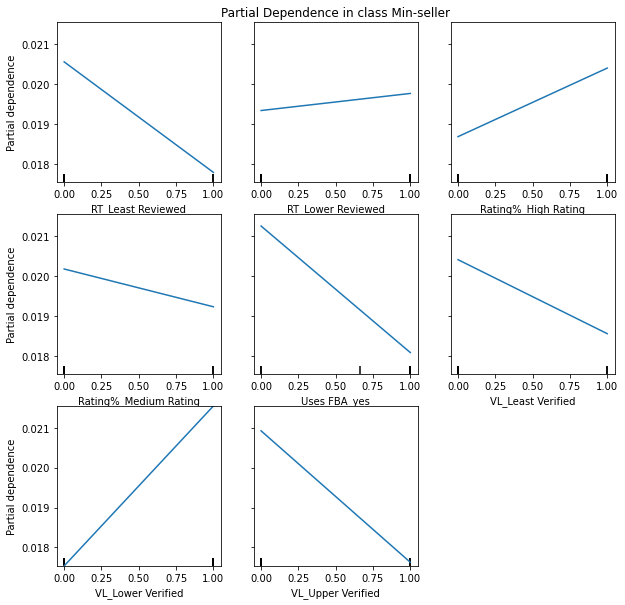

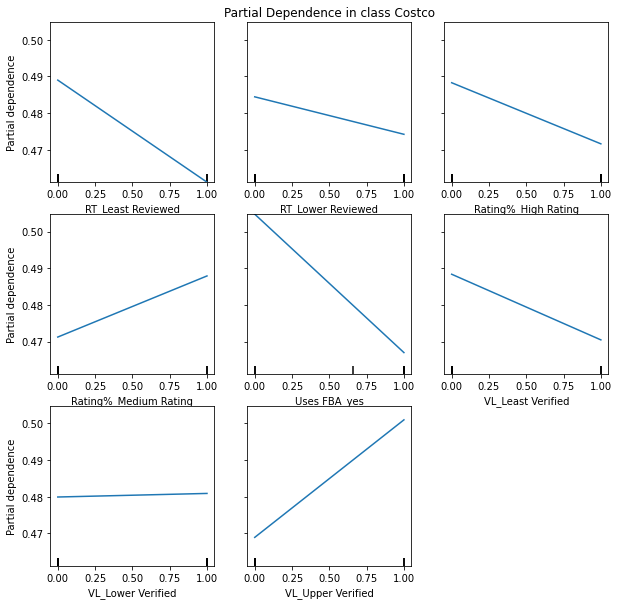

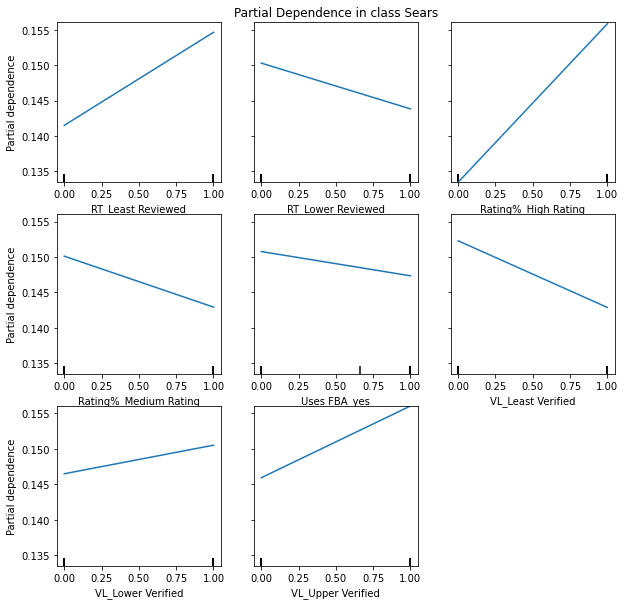

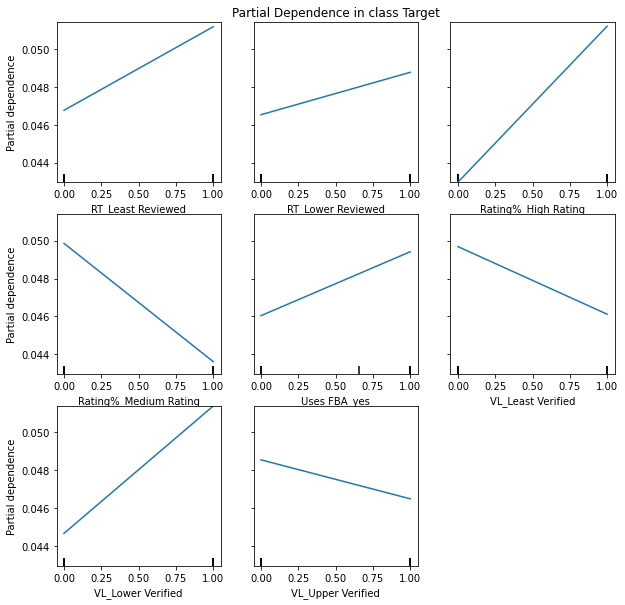

In [19]:
# Other important variables of partial dependence plots

others = list(set(fil) - set(brands+SP))
others.sort()
 
for i in range(len(reso)):
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.set_title("Partial Dependence in class %s" % reso[i])
  plot_partial_dependence(clf, X_train, others, target=i,
                          n_jobs=3, grid_resolution=20,ax=ax)

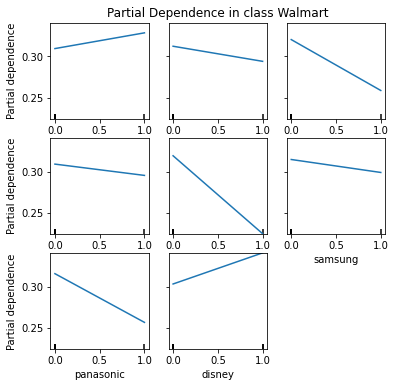

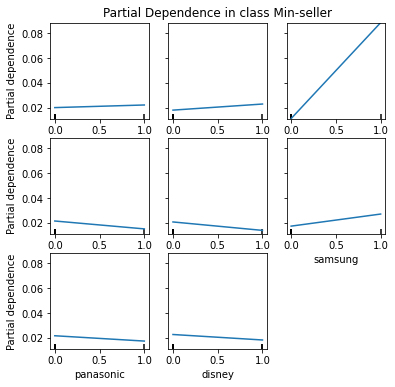

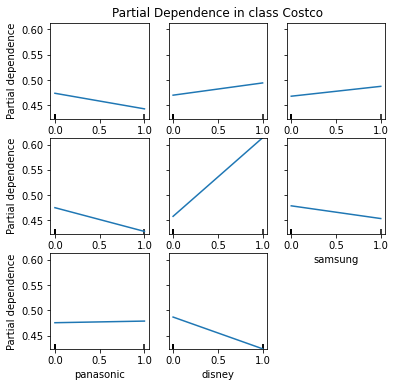

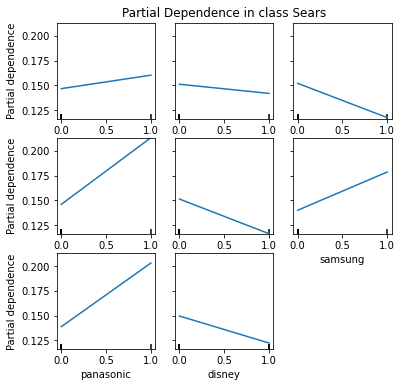

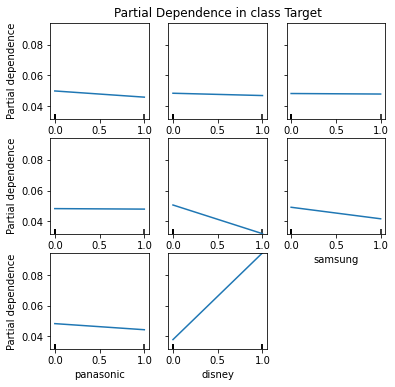

In [81]:
for i in range(len(reso)):
  fig, ax = plt.subplots(figsize=(6, 6))
  ax.set_title("Partial Dependence in class %s" % reso[i])
  plot_partial_dependence(clf, X_train, brands, target=i,
                          n_jobs=3, grid_resolution=20, ax=ax)

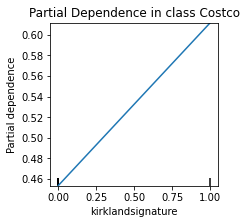

In [79]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title("Partial Dependence in class %s" % reso[2])
plot_partial_dependence(clf, X, ['kirklandsignature'],target=2,
                          n_jobs=3, grid_resolution=20, ax=ax)

In [22]:
pd.DataFrame(df.groupby('target_reso')['Uses FBA_yes'].value_counts(normalize=False))

Uses FBA_yes
target_reso Uses FBA_yes              
0           1                      411
            0                      151
1           1                       19
            0                       15
2           1                      660
            0                      305
3           1                      192
            0                       92
4           1                       74
            0                       11

In [23]:
pd.DataFrame(df.groupby('Uses FBA_yes')['target_reso'].value_counts(normalize=True))

target_reso
Uses FBA_yes target_reso             
0            2               0.531359
             0               0.263066
             3               0.160279
             1               0.026132
             4               0.019164
1            2               0.486726
             0               0.303097
             3               0.141593
             4               0.054572
             1               0.014012

In [24]:
pd.DataFrame(df.groupby('target_reso')['Uses FBA_yes'].value_counts(normalize=True))

Uses FBA_yes
target_reso Uses FBA_yes              
0           1                 0.731317
            0                 0.268683
1           1                 0.558824
            0                 0.441176
2           1                 0.683938
            0                 0.316062
3           1                 0.676056
            0                 0.323944
4           1                 0.870588
            0                 0.129412

In [0]:
fi = pd.DataFrame(feature_importance, index = X_train.columns, columns=['Feature Importance']).sort_values('Feature Importance',ascending=False)

In [0]:
brandname = df.columns.to_list()[1:102]

In [0]:
fi = fi.reset_index()

In [0]:
fi =fi.rename(columns={'index':'brands'})

In [0]:
fi[fi.brands.isin(brandname)].to_csv('brands.csv')

In [0]:
fi[~fi.brands.isin(brandname)].to_csv('others.csv')